### Домашнє завдання: Пониження розмірностей для Аналізу Портретів Клієнтів

#### Контекст
В цьому ДЗ ми попрацюємо з методами пониження розмірності на наборі даних для задачі аналізу портретів клієнтів (Customer Personality Analysis). **В попередньому ДЗ ми працювали з цими даними використовуючи кластеризацію, зараз використаємо кластеризацію і візуалізауємо результати з різними методами.**

Customer Personality Analysis - це аналіз різних сегментів клієнтів компанії. Цей аналіз дозволяє бізнесу краще розуміти своїх клієнтів і полегшує процес адаптації продуктів під конкретні потреби, поведінку та інтереси різних типів клієнтів.

Аналіз портретів клієнтів допомагає бізнесу змінювати свій продукт на основі цільової аудиторії, розділеної на різні сегменти. Наприклад, замість того, щоб витрачати гроші на маркетинг нового продукту для всіх клієнтів у базі даних компанії, бізнес може проаналізувати, який сегмент клієнтів найімовірніше придбає продукт, і потім зосередити маркетингові зусилля лише на цьому сегменті.

#### Вхідні дані
Вам надано набір даних з такими атрибутами:

**Характеристики користувачів:**
- `ID`: Унікальний ідентифікатор клієнта
- `Year_Birth`: Рік народження клієнта
- `Education`: Рівень освіти клієнта
- `Marital_Status`: Сімейний стан клієнта
- `Income`: Річний дохід домогосподарства клієнта
- `Kidhome`: Кількість дітей у домогосподарстві клієнта
- `Teenhome`: Кількість підлітків у домогосподарстві клієнта
- `Dt_Customer`: Дата реєстрації клієнта у компанії
- `Recency`: Кількість днів з моменту останньої покупки клієнта
- `Complain`: 1, якщо клієнт скаржився за останні 2 роки, 0 - якщо ні

**Продукти:**
- `MntWines`: Сума, витрачена на вино за останні 2 роки
- `MntFruits`: Сума, витрачена на фрукти за останні 2 роки
- `MntMeatProducts`: Сума, витрачена на м'ясні продукти за останні 2 роки
- `MntFishProducts`: Сума, витрачена на рибні продукти за останні 2 роки
- `MntSweetProducts`: Сума, витрачена на солодощі за останні 2 роки
- `MntGoldProds`: Сума, витрачена на золото за останні 2 роки

**Акції:**
- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць


Для початку, запустіть код нижче. Всі ці кроки ми робили в попередньому ДЗ і для того, щоб результати кластеризації у нас були схожими, потрібно аби передобробка була однаковою.

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [1]:
# 1. Завантаження даних
df = pd.read_csv('marketing_campaign.csv', sep='\t')

# 2. Обробка пропущених значень
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

# 3. Обробка дати реєстрації
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)

# 4. Категоризація рівня освіти
df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)

# 5. Очищення сімейного стану
marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)

# 6. Форматування доходу і видалення викиду
df.Income = df.Income.astype(int)
df = df[df.Income != 666666]

# 7. Створення фінального набору даних
X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

### Завдання 1: Виконання кластеризації та пониження розмірності для візуалізації результатів

Ваше завдання — провести кластеризацію клієнтів та візуалізувати результати кластеризації, використовуючи метод головних компонент (PCA) для пониження розмірності даних.

#### Інструкції:

1. **Вибір ключових характеристик:**
   Давайте обмежимось тільки наступними хараткеристиками для кластеризації цього разу:
   - `Income`: Річний дохід домогосподарства клієнта
   - `Recency`: Кількість днів з моменту останньої покупки клієнта
   - `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
   - `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
   - `days_lifetime`: Кількість днів з моменту реєстрації клієнта у компанії
   - `years_customer`: Вік клієнта
   - `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць
   Відберіть в наборі даних `X` лише ці характеристики.

2. **Стандартизація даних:**
   Використайте метод `StandardScaler` для стандартизації значень обраних характеристик.
   
   **Чому не MinMaxScaler:**
   - Для PCA краще використовувати StandardScaler, бо він вирівнює дисперсію ознак, на відміну від MinMaxScaler, що просто масштабує значення без врахування варіації.

   - Для K-Means також краще використовувати StandardScaler, бо алгоритм чутливий до масштабів: фічі з більшими значеннями сильніше впливають на обчислення відстаней, що може спотворити кластери.

3. **Кластеризація:**
   Проведіть кластеризацію клієнтів, використовуючи метод `KMeans` з трьома кластерами.

4. **Пониження розмірності:**
   Використайте метод головних компонент (PCA) для пониження розмірності даних до трьох компонент.

5. **Візуалізація результатів:**
   Використовуючи plolty express побудуйте 3D-графік розподілу клієнтів у просторі трьох головних компонент, де кольором позначено кластери.

6. **Опишіть, що спостерігаєте:**
   Чи кластеризація чітко розділила дані?

Далі ми детальніше проінтерпретуємо результати візуалізації і пониження розмірностей.

In [6]:
#1. Вибір ключових характеристик
features = [
    'Income',
    'Recency',
    'NumStorePurchases',
    'NumDealsPurchases',
    'days_lifetime',
    'years_customer',
    'NumWebVisitsMonth'
]
X_selected = X[features]

#2. Стандартизація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [7]:
# 3. Кластеризація (KMeans з 3 кластерами)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X['Cluster'] = kmeans.fit_predict(X_scaled)

In [8]:
# 4. Пониження розмірності до 3 компонент
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

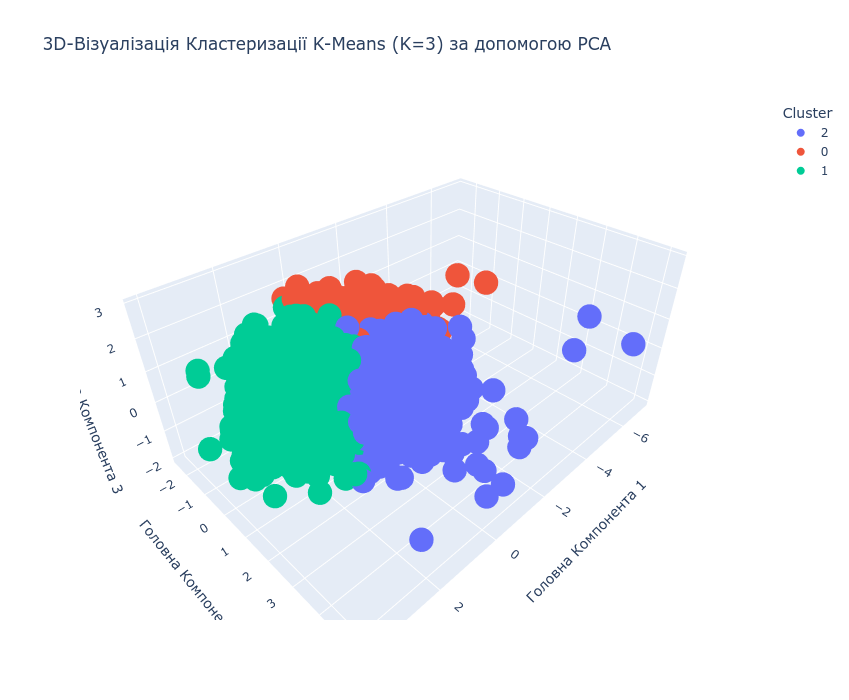

In [10]:
# 5. Візуалізація результатів
pca_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = X['Cluster'].astype(str)

fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='3D-Візуалізація Кластеризації K-Means (K=3) за допомогою PCA',
    labels={'PC1': 'Головна Компонента 1', 'PC2': 'Головна Компонента 2', 'PC3': 'Головна Компонента 3'},
    height=700
)

fig.show()

Інтерпретація

- Ні, кластеризація не розділила дані ідеально чітко, але виділила три кластери, які дещо перекриваються.  
- Головна Компонента 1 (PC1) виглядає як найбільш дискримінативний фактор, розділяючи Кластер 1  та Кластер 0. Головна Компонента 3 (PC3) найбільше розділяє Кластер 0 від Кластера 2.

Для подальшої інтерпретації необхідно проаналізувати, які саме вихідні характеристики (Дохід, Recency, Покупки в магазині тощо) відповідають за ці відмінності, порівнюючи середні значення цих атрибутів у кожному кластері.

### Завдання 2: Аналіз результатів пониження розмірності

1. **Розрахунок частки поясненої дисперсії:**
   Визначте, яка частка загальної варіації даних пояснюється кожною з трьох головних компонент (PC1, PC2, PC3) за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA. Виведіть результат на екран.

2. **Розрахунок кумулятивної частки поясненої дисперсії:**
   Обчисліть кумулятивну частку поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [13]:
# 1. Частка поясненої дисперсії для кожної компоненти
explained_variance_ratio = pca.explained_variance_ratio_

print("Частка поясненої дисперсії для кожної головної компоненти:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

Частка поясненої дисперсії для кожної головної компоненти:
PC1: 0.3185 (31.85%)
PC2: 0.1966 (19.66%)
PC3: 0.1434 (14.34%)


In [16]:
# 2. Розрахунок кумулятивної частки поясненої дисперсії
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

print("Кумулятивна частка поясненої дисперсії:")
for i, cum_ratio in enumerate(cumulative_explained_variance_ratio):
    print(f"PC1 до PC{i+1}: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")

Кумулятивна частка поясненої дисперсії:
PC1 до PC1: 0.3185 (31.85%)
PC1 до PC2: 0.5151 (51.51%)
PC1 до PC3: 0.6585 (65.85%)


### Завдання 3: Інтерпретація "Loadings"

Продовжуємо інтерпретацію результатів `PCA`і познайомимось з новим поняттям `loadings`, яке допоможе нам знайти звʼязок між головними компонентами і оригінальними ознаками в наборі даних.

Ми зараз побудували візуалізацію кластерів точок даних в просторі трьох головних компонент. Але хочеться знайти звʼязок між головними компонентами і оригінальними ознаками. Для розуміння, які початкові характеристики даних мають найбільший вплив на ці головні компоненти, ми можемо використати атрибут `components_` методу `PCA`.

#### Що таке `pca.components_`?

`pca.components_` — це масив, який містить коефіцієнти (або "ваги"), що показують внесок кожної вихідної ознаки у кожну з головних компонент. Ці коефіцієнти ще називаються **"loading"** або "навантаженнями" компонент.

- **Loadings** (`навантаження`) відображають важливість кожної змінної (ознаки) для відповідної головної компоненти. Вони показують, яким чином змінні поєднуються, щоб утворити нові, зменшені вимірювання.
- Якщо коефіцієнт має високе абсолютне значення (як позитивне, так і негативне), це вказує на те, що відповідна змінна сильно впливає на головну компоненту.

#### Саме завдання
Ваше завдання — обчислити "навантаження" для кожної з головних компонент і інтерпретувати результати.

1. **Обчислення loadings для компонент:**
   Використайте атрибут `components_` об'єкта PCA для створення DataFrame, який відображатиме внесок кожної вихідної ознаки в кожну головну компоненту.

2. **Інтерпретація результатів:**
   Виведіть значення "навантажень" і проаналізуйте, які ознаки найбільше впливають на кожну головну компоненту.

In [17]:
# 1. Обчислення loadings для компонент:
loadings = pd.DataFrame(
    data=pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=features
)

print("Коефіцієнти навантаження (Loadings) для Головних Компонент:")
print(loadings.round(4))

Коефіцієнти навантаження (Loadings) для Головних Компонент:
                      PC1     PC2     PC3
Income             0.5842  0.1653 -0.0445
Recency            0.0101  0.0368  0.9758
NumStorePurchases  0.4886  0.3847 -0.0806
NumDealsPurchases -0.1987  0.6081 -0.0348
days_lifetime     -0.1327  0.6026 -0.0222
years_customer     0.1894  0.2089  0.1934
NumWebVisitsMonth -0.5717  0.2163 -0.0158


### Завдання 4

Давайте проаналізуємо "навантаження" (**loadings**) для трьох головних компонент після вилучення ознаки `Income`. Це допоможе нам зрозуміти, як змінилася важливість інших ознак для кожної головної компоненти, коли одна з ключових характеристик (`Income`) була вилучена.

#### Кроки для проведення аналізу і ваше завдання:

1. Видаліть ознаку `Income` з нашого набору даних `X` і повторно виконайте PCA (метод головних компонент) для отримання нових "навантажень".

2. Обчисліть нові "навантаження" для трьох головних компонент на наборі даних без `Income`

3. Проаналізуйте, які ознаки мають найбільший вплив на кожну головну компоненту після вилучення `Income`.

4. Перегляньте, наскільки кожна з головних компонент пояснює дисперсію в даних без ознаки `Income`.

In [18]:
# 1. Вилучення ознаки Income
features_no_income = [
    'Recency',
    'NumStorePurchases',
    'NumDealsPurchases',
    'days_lifetime',
    'years_customer',
    'NumWebVisitsMonth'
]
X_selected_no_income = X[features_no_income]

# 2. Стандартизація даних
scaler_no_income = StandardScaler()
X_scaled_no_income = scaler_no_income.fit_transform(X_selected_no_income)

# 3. Повторне навчання PCA (n_components=3)
pca_no_income = PCA(n_components=3)
pca_no_income.fit(X_scaled_no_income)

,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [19]:
# 4. Обчислення нових loadings
loadings_no_income = pd.DataFrame(
    data=pca_no_income.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=features_no_income
)

print("Коефіцієнти навантаження (Loadings) без Income:")
print(loadings_no_income.round(4))

Коефіцієнти навантаження (Loadings) без Income:
                      PC1     PC2     PC3
Recency           -0.0144  0.0749  0.9902
NumStorePurchases -0.3812  0.6292 -0.1111
NumDealsPurchases  0.4456  0.4615 -0.0618
days_lifetime      0.3838  0.4679  0.0068
years_customer    -0.1773  0.3936  0.0563
NumWebVisitsMonth  0.6908 -0.1079  0.0099


Вилучення ознаки Income призвело до наступних ключових структурних змін:

- PC1 Поглинула Онлайн-Складову: Оскільки Income більше не існує для формування фінансової осі, PC1 взяла на себе роль найбільшого роздільника, зосередившись на онлайн-взаємодії та поведінці, орієнтованій на вигоду.

- PC2 Виділила Офлайн-Перевагу: PC2 стала чіткішою віссю для ідентифікації клієнтів, які переважно роблять покупки в магазині.

- PC3 Залишилася Стабільною: Це підтверджує, що Recency є незалежним, одновимірним фактором у цьому наборі даних.

### Завдання 5: Візуалізація кластеризації за допомогою t-SNE

Ваше завдання — використати метод t-SNE для візуалізації результатів кластеризації клієнтів у двовимірному просторі. Метод t-SNE допомагає знизити розмірність даних та зберегти локальні структури в даних, що робить його ефективним для візуалізації високорозмірних даних. Ми також зможемо порівняти результат цього методу з РСА.

1. Використайте метод t-SNE для зниження розмірності до 2х вимірів даних, які включають ознаки всі, що і в завданні 1, а також були відмасштабовані перед пониженням розмірностей.

2. Створіть новий DataFrame з координатами, отриманими після застосування t-SNE, та додайте до нього мітки кластерів.

3. Побудуйте інтерактивний 2D-графік розподілу клієнтів, де кольором буде позначено різні кластери і проаналізуйте графік з рекомендаціями нижче (можливо треба буде вивести додаткові візуалізації чи таблиці для інтерпретації, але треба прям зрозуміти, які ознаки формують який кластер і чим кластери відрізняються одне від одного).

  **Опишіть отримані кластери з точки зору ознак.**

4. Опишіть відмінність графіка tSNE від PCA.

#### ЯК можна інтерпретувати з t-SNE?

Хоча t-SNE не надає "компонентів" як РСА, він забезпечує низьковимірне представлення даних, яке можна візуально інтерпретувати:

- **Кластери:** t-SNE особливо добре показує кластери подібних точок. Якщо ви бачите чітко визначені кластери на графіку t-SNE, це свідчить про наявність груп схожих спостережень у ваших даних. Проаналізувати їх можемо, якщо додамо дані в `hover_data` або якщо якісь з даних виведемо як розмір чи форма точок на візуалізації. Також корисно може бути вивести середні значення ознак по кластерам.
- **Локальна структура:** Відносне розташування точок одного кластеру на графіку t-SNE може допомогти вам зрозуміти, які дані подібні між собою.
- **Глобальна структура:** Будьте обережні; t-SNE менш надійний для відображення глобальних структур (наприклад, відстаней між кластерами) у порівнянні з PCA, бо t-SNE націлений на збереження саме локальних структур.

In [21]:
# 2. Застосування t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_scaled)

In [22]:
# 3. Створення DataFrame для візуалізації
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = X['Cluster'].astype(str)

# Додамо вихідні ознаки для кращої інтерпретації за допомогою hover_data
for feature in features:
    tsne_df[feature] = X[feature]

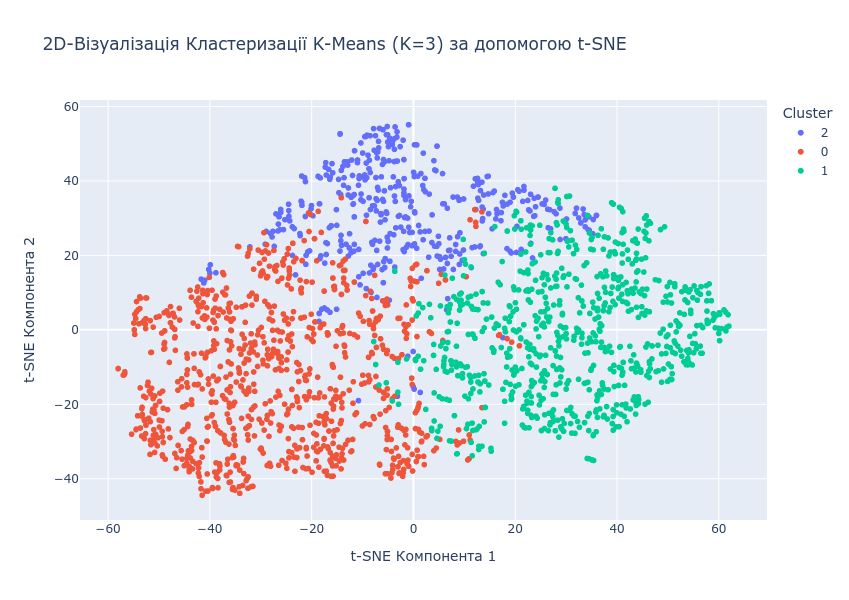

In [23]:
# Побудова інтерактивного 2D-графіка
fig = px.scatter(
    tsne_df,
    x='TSNE1',
    y='TSNE2',
    color='Cluster',
    title='2D-Візуалізація Кластеризації K-Means (K=3) за допомогою t-SNE',
    labels={'TSNE1': 't-SNE Компонента 1', 'TSNE2': 't-SNE Компонента 2'},
    hover_data=features,
    height=600
)

fig.show()

In [25]:
cluster_analysis = X.groupby('Cluster')[features].mean().round(2)
print("Середні значення ключових ознак за кластерами:")
cluster_analysis

Середні значення ключових ознак за кластерами:


,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
Cluster,,,,,,,
0,33054.88,48.47,3.17,1.81,312.55,41.91,6.51
1,72551.55,49.35,8.34,1.44,315.25,47.35,3.07
2,51950.66,50.09,6.71,5.00,509.48,48.24,6.87


1. Кластер 1: Преміум-Покупці 
- Найзаможніший сегмент (Дохід ≈72.5k).
- Максимальна кількість покупок у магазинах (8.34) і мінімальна веб-активність (3.07).
- Найменше використовують знижки.

2. Кластер 2: Покупці які шукають знижки  
- Середній дохід (≈52.0k), але найдовший термін співпраці (≈509 днів) та найстарший вік.  
- Надзвичайно висока кількість покупок зі знижками (5.00).
- Помірні покупки в магазині.
- Клієнти, які активно реагують на акційні пропозиції. 

3. Кластер 0: Бюджетні онлайн-покупці
- Найменший дохід (≈33.1k).
- Максимальна веб-активність (6.51) і найменша кількість покупок у магазинах (3.17).
- Бюджетний, онлайн-орієнтований сегмент.
- Вони багато часу проводять на сайті (ймовірно, порівнюючи ціни), але через обмежений бюджет є найменш прибутковими.

In [28]:
# Силуетний коефіцієнт
silhouette_avg = silhouette_score(X_scaled, X['Cluster'])

print(f"Кількісна оцінка якості кластеризації K-Means (K=3):")
print(f"Silhouette Score:          {silhouette_avg:.4f}")

Кількісна оцінка якості кластеризації K-Means (K=3):
Silhouette Score:          0.2150
